<font size='5'>Loss of Auto-Correlation</font>

This notebook demonstrates how sampling from the posterior does not preserve auto-correlation. 

In [100]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent state. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [101]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [102]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. 1st-order differencing of the log price for each asset. View auto-correlation.

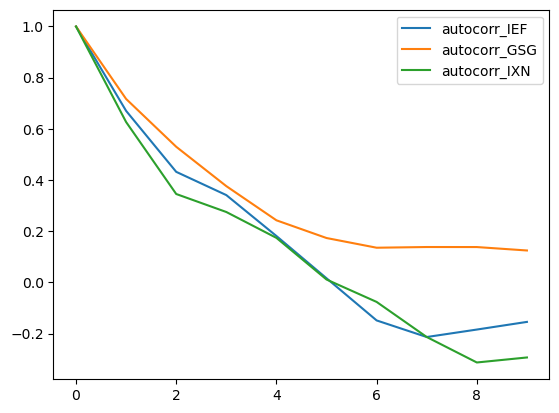

In [103]:
m6_subset = m6_assets.copy().apply(np.log).rolling(9).mean().apply(np.diff)
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 10)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 10)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 10)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample 255 separate individual draws from the variational model. This sampling should respect the empirical transition matrix of the data.

In [104]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')

In [105]:
dpgmm_model.fit(m6_subset)

get_col = lambda sampler, M: [ s[M] for s in sampler ]
states = []
samples = []

for s in range(255):
    sample, y = dpgmm_model.sample(1)
    states.append(y[0])
    samples.append(sample[0])

df = pd.DataFrame()
df['0']=get_col(samples, 0)
df['1']=get_col(samples, 1)
df['2']=get_col(samples, 2)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

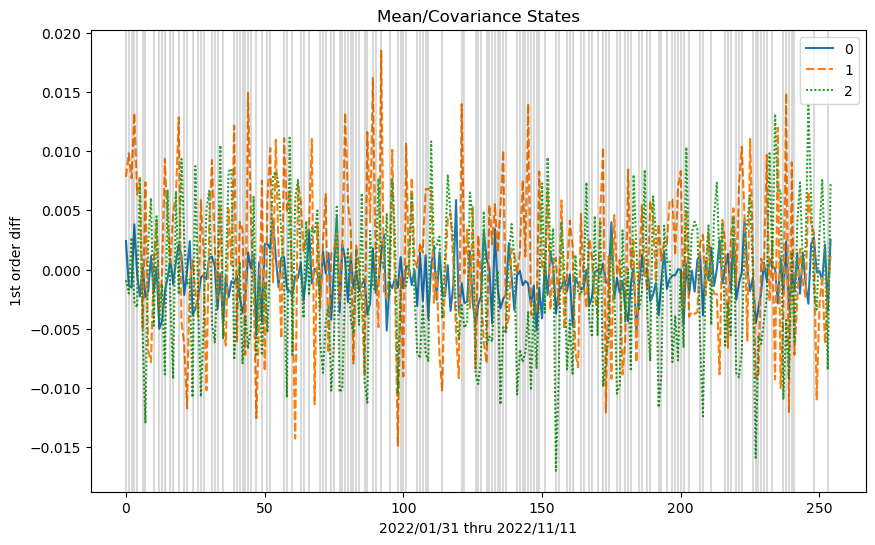

In [106]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=df, ax=ax)

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean/Covariance States')
ax.set_ylabel('1st order diff')
ax.set_xlabel(f'2022/01/31 thru 2022/11/11')
plt.show()

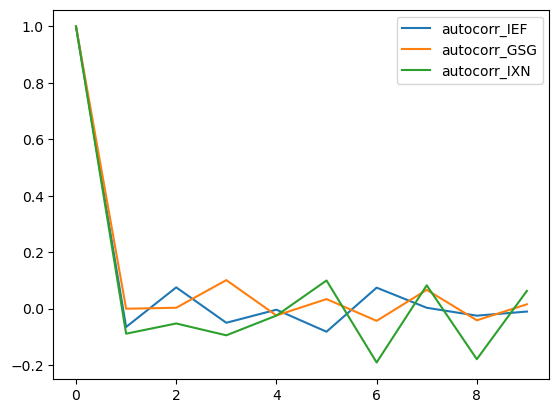

In [107]:
sns.lineplot(data=decay_func(df['0'].apply(abs), range(0, 10)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(df['1'].apply(abs), range(0, 10)), label='autocorr_GSG')
sns.lineplot(data=decay_func(df['2'].apply(abs), range(0, 10)), label='autocorr_IXN')
plt.show()